In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/customer-segmentation-tutorial-in-python/Mall_Customers.csv


In [2]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score

In [3]:
# Load dataset
data = pd.read_csv('/kaggle/input/customer-segmentation-tutorial-in-python/Mall_Customers.csv')

# Display the first few rows
data.head()

,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40


# Exploratory Data Analysis (EDA) 

There are 4 columns for each customer ID to give us some insight into different customer categories. The features are all numeric except for 'gender.' It will make things easier down the line to switch this column to also be in numeric format. We will turn 'gender' into a binary column with 1 for male and 0 for female. 

We also need to check to see how these values are distibuted and if there are any missing values we will need to deal with. 

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

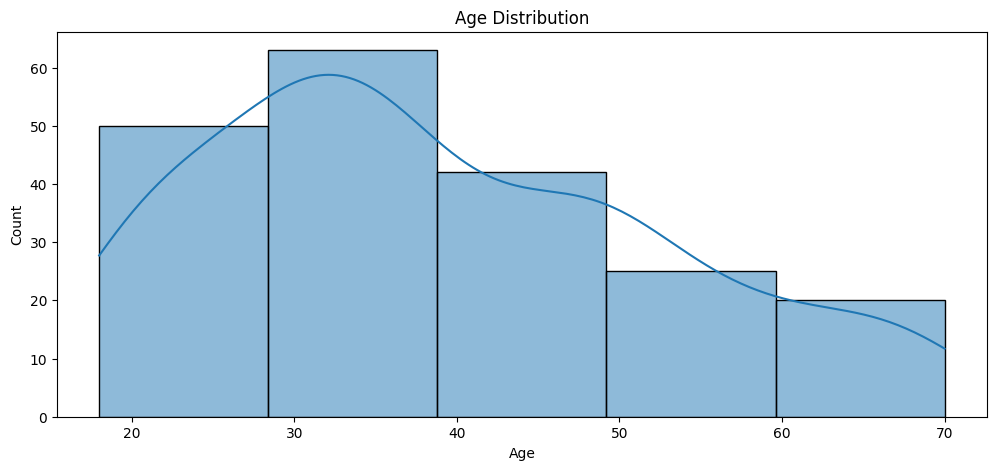

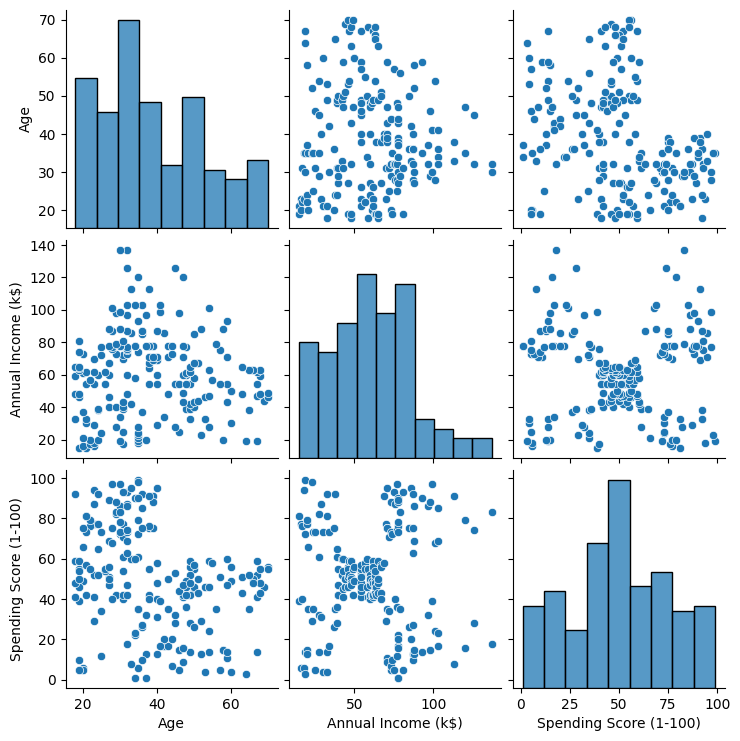

In [4]:
# Distribution plots
plt.figure(figsize=(12, 5))
sns.histplot(data['Age'], kde=True, bins=5)
plt.title('Age Distribution')

# Pairplot to visualize relationships
sns.pairplot(data[['Age', 'Annual Income (k$)', 'Spending Score (1-100)']])
plt.show()

In [5]:
# Check for missing values
print(data.isnull().sum())

# Encode Gender
data['Gender'] = data['Gender'].map({'Male': 1, 'Female': 0})

# Drop irrelevant columns (like CustomerID)
data_cleaned = data.drop('CustomerID', axis=1)

# Normalize numerical features
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data_cleaned[['Age', 'Annual Income (k$)', 'Spending Score (1-100)']])

CustomerID                0
Gender                    0
Age                       0
Annual Income (k$)        0
Spending Score (1-100)    0
dtype: int64


Great, no missing values! 

Let's move forward with dropping the customer ID column since this isn't really giving us any information to help the model. Finally, we will normalize the numeric features. This will help make sure numbers on different scales (age vs. annual income) are handled appropriately in the algorithim. 

# Build the clusters 

We'll start buy finding the ideal number of clusters usin the elbow method. This will help us visualize the point where points are grouped closely around a centroid (best clustering) compared to where the number of clusters shows minimal improvement. The "point" of the elbow shows us where the best k value is. 

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

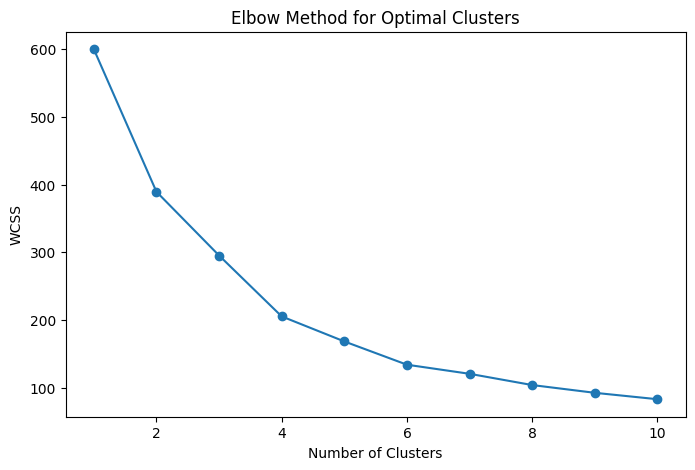

In [13]:
# Determine optimal number of clusters (Elbow Method)
wcss = []  # Within-cluster sum of squares
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, random_state=42)
    kmeans.fit(data_scaled)
    wcss.append(kmeans.inertia_)

# Plot Elbow Curve
plt.figure(figsize=(8, 5))
plt.plot(range(1, 11), wcss, marker='o')
plt.title('Elbow Method for Optimal Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.show()

# Apply KMeans with the chosen number of clusters
kmeans = KMeans(n_clusters=4, random_state=42)
clusters = kmeans.fit_predict(data_scaled)
data_cleaned['Cluster'] = clusters

# Evaluate & Visualize 

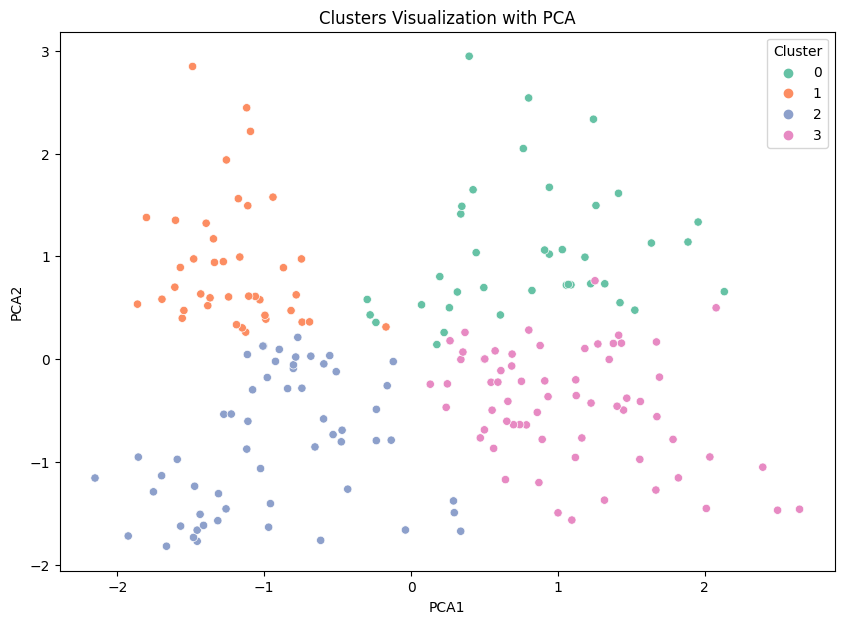

           Gender        Age  Annual Income (k$)  Spending Score (1-100)
Cluster                                                                 
0        0.500000  39.368421           86.500000               19.578947
1        0.450000  32.875000           86.100000               81.525000
2        0.403509  25.438596           40.000000               60.298246
3        0.430769  53.984615           47.707692               39.969231


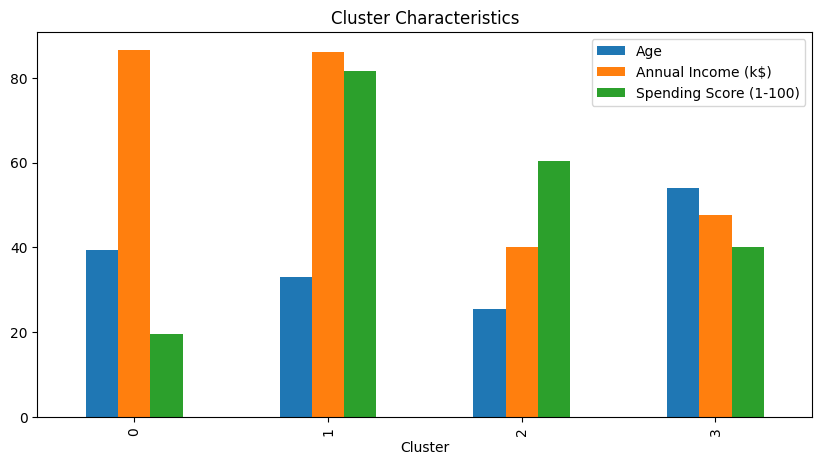

In [7]:
# Visualize clusters in 2D using PCA
pca = PCA(n_components=2)
reduced_data = pca.fit_transform(data_scaled)
reduced_data = pd.DataFrame(reduced_data, columns=['PCA1', 'PCA2'])
reduced_data['Cluster'] = clusters

# Scatter plot
plt.figure(figsize=(10, 7))
sns.scatterplot(data=reduced_data, x='PCA1', y='PCA2', hue='Cluster', palette='Set2')
plt.title('Clusters Visualization with PCA')
plt.show()

# Group data by cluster
cluster_analysis = data_cleaned.groupby('Cluster').mean()
print(cluster_analysis)

# Visualize cluster characteristics
cluster_analysis[['Age', 'Annual Income (k$)', 'Spending Score (1-100)']].plot(kind='bar', figsize=(10, 5))
plt.title('Cluster Characteristics')
plt.show()


# Next steps 

Let's experiment with adding another feature. I will randomly assing parent/grandparent (binary yes or no) with a weight of 65% being parents/grandparents. 

In [15]:
# Add a new feature: Parent_Grandparent (1 = Yes, 0 = No)
np.random.seed(42)  # Ensure reproducibility
data_cleaned['Parent_Grandparent'] = np.random.choice([1, 0], size=data.shape[0], p=[0.65, 0.35])

# Run K-Means with the same optimal K
from sklearn.cluster import KMeans
kmeans_new = KMeans(n_clusters=4, random_state=42)
data_cleaned['Cluster_New'] = kmeans_new.fit_predict(data_cleaned)

KeyError: "['Cluster'] not found in axis"

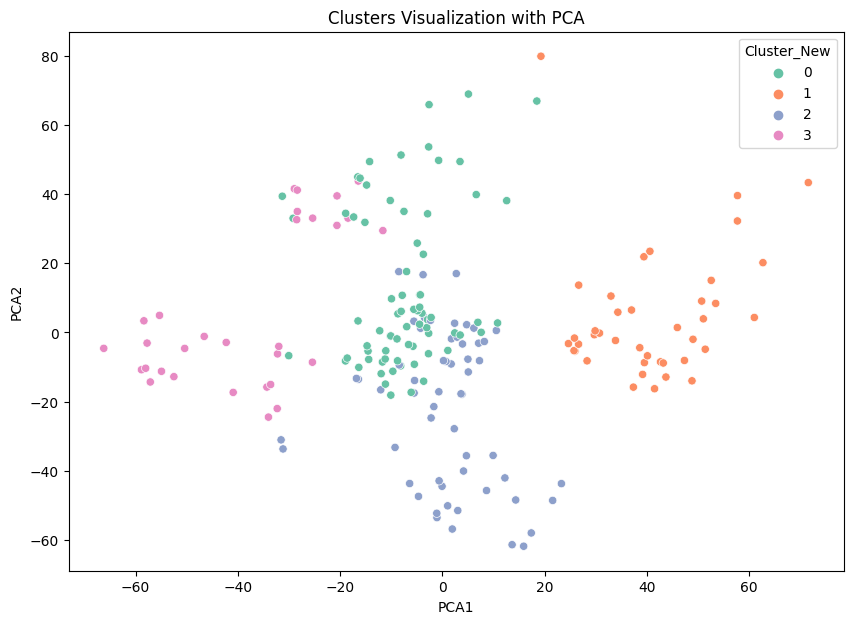

               Gender        Age  Annual Income (k$)  Spending Score (1-100)  \
Cluster_New                                                                    
0            0.526316  40.394737           87.000000               18.631579   
1            0.378947  44.894737           48.705263               42.631579   
2            0.500000  24.821429           28.714286               74.250000   
3            0.461538  32.692308           86.538462               82.128205   

             Parent_Grandparent  
Cluster_New                      
0                      0.631579  
1                      0.673684  
2                      0.642857  
3                      0.717949  


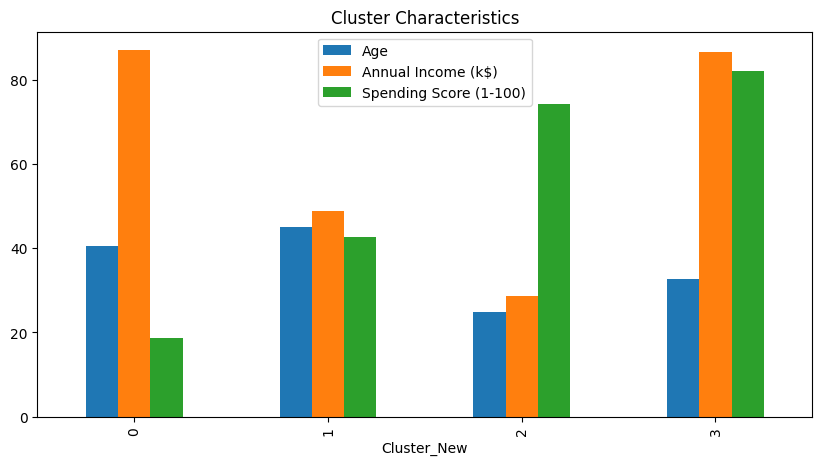

In [16]:
# Visualize clusters in 2D using PCA
pca = PCA(n_components=2)
reduced_data2 = pca.fit_transform(data_cleaned)
reduced_data2 = pd.DataFrame(reduced_data2, columns=['PCA1', 'PCA2'])
reduced_data2['Cluster_New'] = clusters

# Scatter plot
plt.figure(figsize=(10, 7))
sns.scatterplot(data=reduced_data2, x='PCA1', y='PCA2', hue='Cluster_New', palette='Set2')
plt.title('Clusters Visualization with PCA')
plt.show()

# Group data by cluster
cluster_analysis = data_cleaned.groupby('Cluster_New').mean()
print(cluster_analysis)

# Visualize cluster characteristics
cluster_analysis[['Age', 'Annual Income (k$)', 'Spending Score (1-100)']].plot(kind='bar', figsize=(10, 5))
plt.title('Cluster Characteristics')
plt.show()
